First we import our dependencies.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras import backend
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from itertools import product as myzip

We import our data into a dictionary, the keys of which describe the splitting.

In [2]:
my_path = 'D:\s4353631\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [3]:
def format_fn(path):
    '''
    Formats single-channel image (.png) at path as a tf.Tensor of shape suitable 
    for input to a CNN.
    
    Args:
        path (str): Image filepath.
        
    Returns:
        tf.Tensor: formatted tensor representing the image.
    '''
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path, pixels=pixels):
    '''
    Formats x and y single-channel images (.png) as tf.Tensors of shape suitable 
    for input to a CNN. Formatting of y images is performed by separating the pixel 
    values in pixels into discrete Boolean channels along the depth axis.
    
    Args:
        x_path (str): x image (raw input) filepath.
        y_path (str): y image (raw input) filepath.
        
    Returns:
        x (tf.Tensor): Formatted tensor representing the x image.
        y (tf.Tensor): Formatted tensor of Boolean channels representing the y image.
    '''
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [4]:
# Create the datasets for each element of the datasets list (train, validate, test), 
# storing them in data_dict.
for dataset in datasets:
    # Extract the x and y image titles; we know these to match and could generate them
    # from a single glob.glob if preferred. However, this method is useful as it allows 
    # us to check that no images are missing.
    x_paths = glob.glob(my_path + dataset + '/*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '/*.png')
    # Create a tf.data.Dataset from the image filepaths.
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    # Shuffle each dataset at each iteration to prevent data leakage, choosing a large 
    # Shuffling index to safeguard against only shuffling a small portion.
    data_dict[dataset] = data_dict[dataset].shuffle(10**5, reshuffle_each_iteration=True)
    # Apply the path_2_tens map, filling out the datasets.
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

Let's take a quick look to check things worked correctly.

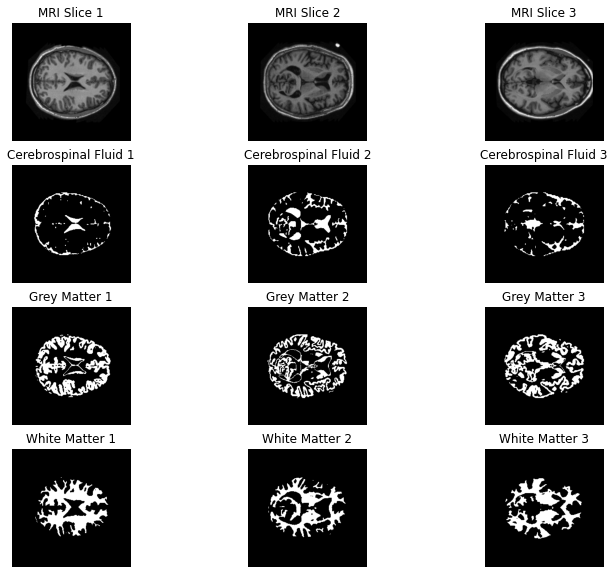

In [5]:
# Extract three samples from the training set using an iterator.
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
# The samples contain each image in the first dimension, the two pixel  
# axes in the second and third dimensions and the channels in the
# fourth dimension. Here we do not require the channel on the x image.
x_sample = tf.reshape(x_sample, [3, 256, 256])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

# For each sample we plot the x image as well as each formatted channel 
# of the y image, making use of the product function from itertools 
# (here renamed myzip in comparison with the standard zip tool).
for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

In [44]:
class My_Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, activation=True, strides=(1, 1), kernel=3, \
            alpha=10^-2, regularizer=tf.keras.regularizers.l2(10^-2), 
            initializer=tf.keras.initializers.he_uniform()):
        '''
        Inherits from tf.keras.layers.Layer, consists of a 3X3 convolution of 
        variable stride passing to an optional activation (tf.keras.layers.LeakyReLU). 
        
        Args:
            filters (int): Number of convolutional filters.
            activation (bool): Whether or not to include activation.
            strides (tuple): Stride in each dimension.
            kernel (int): Square filter side length.
            alpha (float): Gradient of tf.keras.layers.LeakyReLU below activation.
            kernel_regularizer (tf.keras.regularizers): Regularization algorithm.
        '''
        super(My_Conv2D, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, kernel, strides=strides, \
           padding='same', kernel_initializer=initializer)
        self.activation = activation
        if self.activation:
            self.leakyrelu_1 = tf.keras.layers.LeakyReLU(alpha=alpha)
        
    def call(self, x):
        '''
        Defines the forward pass; the backward pass is computed via TensorFlow's 
        autodifferentiation algorithm.
        
        Args:
            x (tf.Tensor): Image tensor, remapped if the layer is deep.
            
        Returns:
            x (tf.Tensor): Image tensor as processed by the layer.
        '''
        x = self.conv2d_1(x)
        if self.activation:
            x = self.leakyrelu_1(x)
        
        return x

class Downshift(tf.keras.layers.Layer):

    def __init__(self, filters, bottom=False, dropout=0):
        '''
        Inherits from tf.keras.layers.Layer, consists of a residual context module 
        passing to a stride 2X2 MyConv2D layer. The residual context module contains 
        two My_Conv2D layers, the first without activation, separated by dropout. 
        The initial tensor is then added element-wise to the output before being 
        stored as x_res and passed to the stride 2X2 convolution with twice as many 
        filters; x_res is later employed for context aggregation by Upshift. An option 
        to not compute the stride 2X2 convolution is included so that the UNet 
        architecture can effectively 'bottom out'. Combining the residual context module 
        with the stride 2X2 convolution in this way is useful for fast prototyping with 
        small networks as these converge much more quickly than larger equivalents, 
        offering a proof of concept.

        Args:
            filters (int): Number of filters to be used in each convolutional layer of 
                the residual context module.
            bottom (bool): Whether or not to 'bottom out' by not including the stride 
                2X2 convolution.
            dropout (float): Dropout probability.
        '''
        
        super(Downshift, self).__init__()
        self.bottom = bottom
        
        self.conv2d_1 = My_Conv2D(filters, activation=False)
        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        self.conv2d_2 = My_Conv2D(filters)
        self.add_1 = tf.keras.layers.Add()
        self.conv2d_3 = My_Conv2D(int(filters * 2), strides=(2, 2))
        
    def call(self, x_init):
        '''
        Defines the forward pass; the backward pass is computed via TensorFlow's 
        autodifferentiation algorithm.
        
        Args:
            x_init (tf.Tensor): Image tensor, remapped if the layer is deep.
            
        If self.bottom is not true:
            
        Returns:
            x (tf.Tensor): Image tensor as processed by the layer.
            x_res (tf.Tensor): Image tensor as processed by the layer, but 
                excluding the stride 2X2 convolution.
                
        If self.bottom is true:
        Returns:
            x_res (tf.Tensor): Image tensor as processed by the layer, but 
                excluding the stride 2X2 convolution.
        '''
        x = self.conv2d_1(x_init)
        x = self.dropout_1(x)
        x = self.conv2d_2(x)
        x_res = self.add_1([x, x_init])
        
        if self.bottom:
            return x_res
        else:
            x = self.conv2d_3(x)

            return x, x_res
    
class Upshift(tf.keras.layers.Layer):
    '''
    Inherits from tf.keras.layers.Layer, consists of an upsampling module passing 
    to a 
    '''
    def __init__(self, filters, top=False):
        super(Upshift, self).__init__()
        self.top = top
        
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = My_Conv2D(filters)
        self.concatenate_1 = tf.keras.layers.Concatenate()
        self.conv2d_2 = My_Conv2D(filters)
        self.conv2d_3 = My_Conv2D(int(filters / 2), kernel=1)
        self.seg_1 = tf.keras.layers.Conv2D(4, 1, activation='softmax', padding='same')
        
    def call(self, X):
        x, x_res = X
        x = self.upsampling_1(x)
        x = self.conv2d_1(x)
        x = self.concatenate_1([x, x_res])
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        x_seg = self.seg_1(x)
        
        if self.top:
            return x_seg
        
        else:
            return x, x_seg

In [8]:
class My_UNet(tf.keras.Model):
    def __init__(self, input_img_shape):
        super(My_UNet, self).__init__()
        self.input_img_shape = input_img_shape
        
        self.conv2d_1 = My_Conv2D(16)
        
        self.downshift_1 = Downshift(16)
        self.downshift_2 = Downshift(32)
        self.downshift_3 = Downshift(64)
        self.downshift_4 = Downshift(128)
        self.downshift_5 = Downshift(256, bottom=True)
        
        self.upshift_1 = Upshift(128)
        self.upshift_2 = Upshift(64)
        self.upshift_3 = Upshift(32)
        self.upshift_4 = Upshift(16, top=True)
        
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.add_1 = tf.keras.layers.Add()
        self.upsampling_2 = tf.keras.layers.UpSampling2D()
        self.add_2 = tf.keras.layers.Add()
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='softmax', padding='same')
        
    def call(self, x_0):
        x_1 = self.conv2d_1(x_0)
        
        x_2, x_2_res = self.downshift_1(x_1)
        x_3, x_3_res = self.downshift_2(x_2)
        x_4, x_4_res = self.downshift_3(x_3)
        x_5, x_5_res = self.downshift_4(x_4)
        x_6 = self.downshift_5(x_5)

        x_7, x_7_seg = self.upshift_1([x_6, x_5_res])
        x_8, x_8_seg = self.upshift_2([x_7, x_4_res])
        x_9, x_9_seg = self.upshift_3([x_8, x_3_res])
        x_10 = self.upshift_4([x_9, x_2_res])
        
        x_11 = self.upsampling_1(x_7_seg)
        x_12 = self.add_1([x_11, x_8_seg])
        x_13 = self.upsampling_1(x_12)
        x_14 = self.add_1([x_13, x_9_seg])
        x_15 = self.upsampling_2(x_14)
        x_16 = self.add_2([x_15, x_10])

        x_17 = self.output_1(x_16)
        
        return x_17
    
    def build_graph(self):
        x_0 = tf.keras.Input(shape=self.input_img_shape)
        
        return tf.keras.Model(inputs=[x_0], outputs=self.call(x_0))

In [35]:
def dice_coe(y_ground, y_predicted):
    intersection = backend.sum(y_ground * y_predicted, axis=(1, 2))
    union = backend.sum(y_ground + y_predicted, axis=(1, 2))
    
    return 1 - 2 * (intersection) / (union)

In [15]:
def smoothed_jaccard_distance(y_ground, y_predicted, smoothing=10):
    intersection = backend.sum(y_ground*y_predicted, axis=(1, 2))
    union = backend.sum(y_ground + y_predicted, axis=(1, 2))
    jaccard_index = (intersection + smoothing)/(union - intersection + smoothing)
    
    return (1 - jaccard_index)*smoothing

In [55]:
input_img_shape = (256, 256, 1)
model = My_UNet(input_img_shape)

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     10**-5,
#     decay_steps=10**3,
#     decay_rate=0.9,
#     staircase=True)
# my_opt = adam(learning_rate=lr_schedule)
# my_opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.1, \
#     nesterov=True)

model.compile(optimizer='adam', 
              loss=smoothed_jaccard_distance)

model.build(input_shape=(None, *input_img_shape))

model.build_graph().summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
my__conv2d_324 (My_Conv2D)      (None, 256, 256, 16) 160         input_13[0][0]                   
__________________________________________________________________________________________________
downshift_58 (Downshift)        ((None, 128, 128, 32 9280        my__conv2d_324[0][0]             
__________________________________________________________________________________________________
downshift_59 (Downshift)        ((None, 64, 64, 64), 36992       downshift_58[0][0]               
___________________________________________________________________________________________

In [33]:
tf.keras.utils.plot_model(model.build_graph(), show_layer_names=False)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
history = model.fit(data_dict['train'].batch(2), epochs=3,
                    validation_data=data_dict['validate'].batch(2), verbose=1)

In [ ]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()

In [51]:
class Your_UNet(tf.keras.Model):
    def __init__(self, input_img_shape):
        super(Your_UNet, self).__init__()
        self.input_img_shape = input_img_shape
        
        self.conv2d_1 = My_Conv2D(16)
        
        self.downshift_1 = Downshift(16)
        self.downshift_2 = Downshift(32)
        self.downshift_3 = Downshift(64, bottom=True)
        
        self.upshift_1 = Upshift(32, top=True)
        self.upshift_2 = Upshift(16, top=True)
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='softmax', padding='same')
        
    def call(self, x_0):
        x_1 = self.conv2d_1(x_0)
        
        x_2, x_2_res = self.downshift_1(x_1)
        x_3, x_3_res = self.downshift_2(x_2)
        x_4 = self.downshift_3(x_3)

        x_5 = self.upshift_1([x_4, x_3_res])
        x_6 = self.upshift_2([x_5, x_2_res])

        x_7 = self.output_1(x_6)
        
        return x_7
    
    def build_graph(self):
        x_0 = tf.keras.Input(shape=self.input_img_shape)
        
        return tf.keras.Model(inputs=[x_0], outputs=self.call(x_0))

In [60]:
input_img_shape = (256, 256, 1)
model = Your_UNet(input_img_shape)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    10**-3,
    decay_steps=10**3,
    decay_rate=0.7,
    staircase=True)
my_opt = adam(learning_rate=lr_schedule)

model.compile(optimizer=my_opt, 
              loss=smoothed_jaccard_distance)

model.build(input_shape=(None, *input_img_shape))

model.build_graph().summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
my__conv2d_227 (My_Conv2D)      (None, 256, 256, 16) 160         input_11[0][0]                   
__________________________________________________________________________________________________
downshift_42 (Downshift)        ((None, 128, 128, 32 9280        my__conv2d_227[0][0]             
__________________________________________________________________________________________________
downshift_43 (Downshift)        ((None, 64, 64, 64), 36992       downshift_42[0][0]               
___________________________________________________________________________________________

In [ ]:
history = model.fit(data_dict['train'].batch(2), epochs=3,
    validation_data=data_dict['validate'].batch(2), verbose=1)

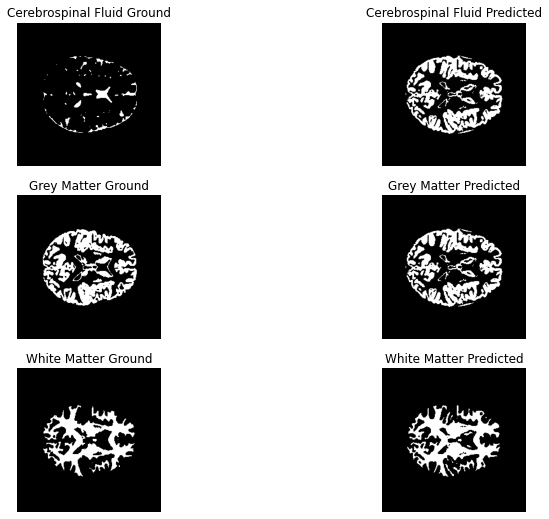

In [62]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()